# Library Imports

In [59]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pickle
from wordcloud import WordCloud

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Exploring Fake News

In [3]:
fake = pd.read_csv("./dataset/data/Fake.csv")

In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
#Counting by Subjects 
for key,count in fake.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
#Getting Total Rows
print(f"Total Records:\t{fake.shape[0]}")

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


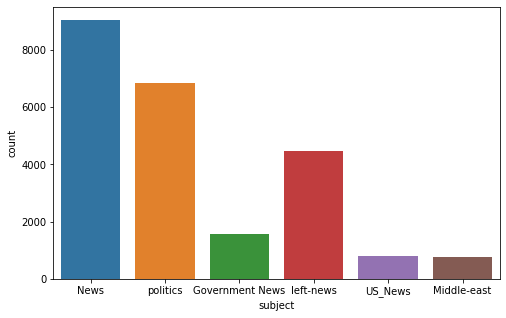

In [6]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=fake)
plt.show()

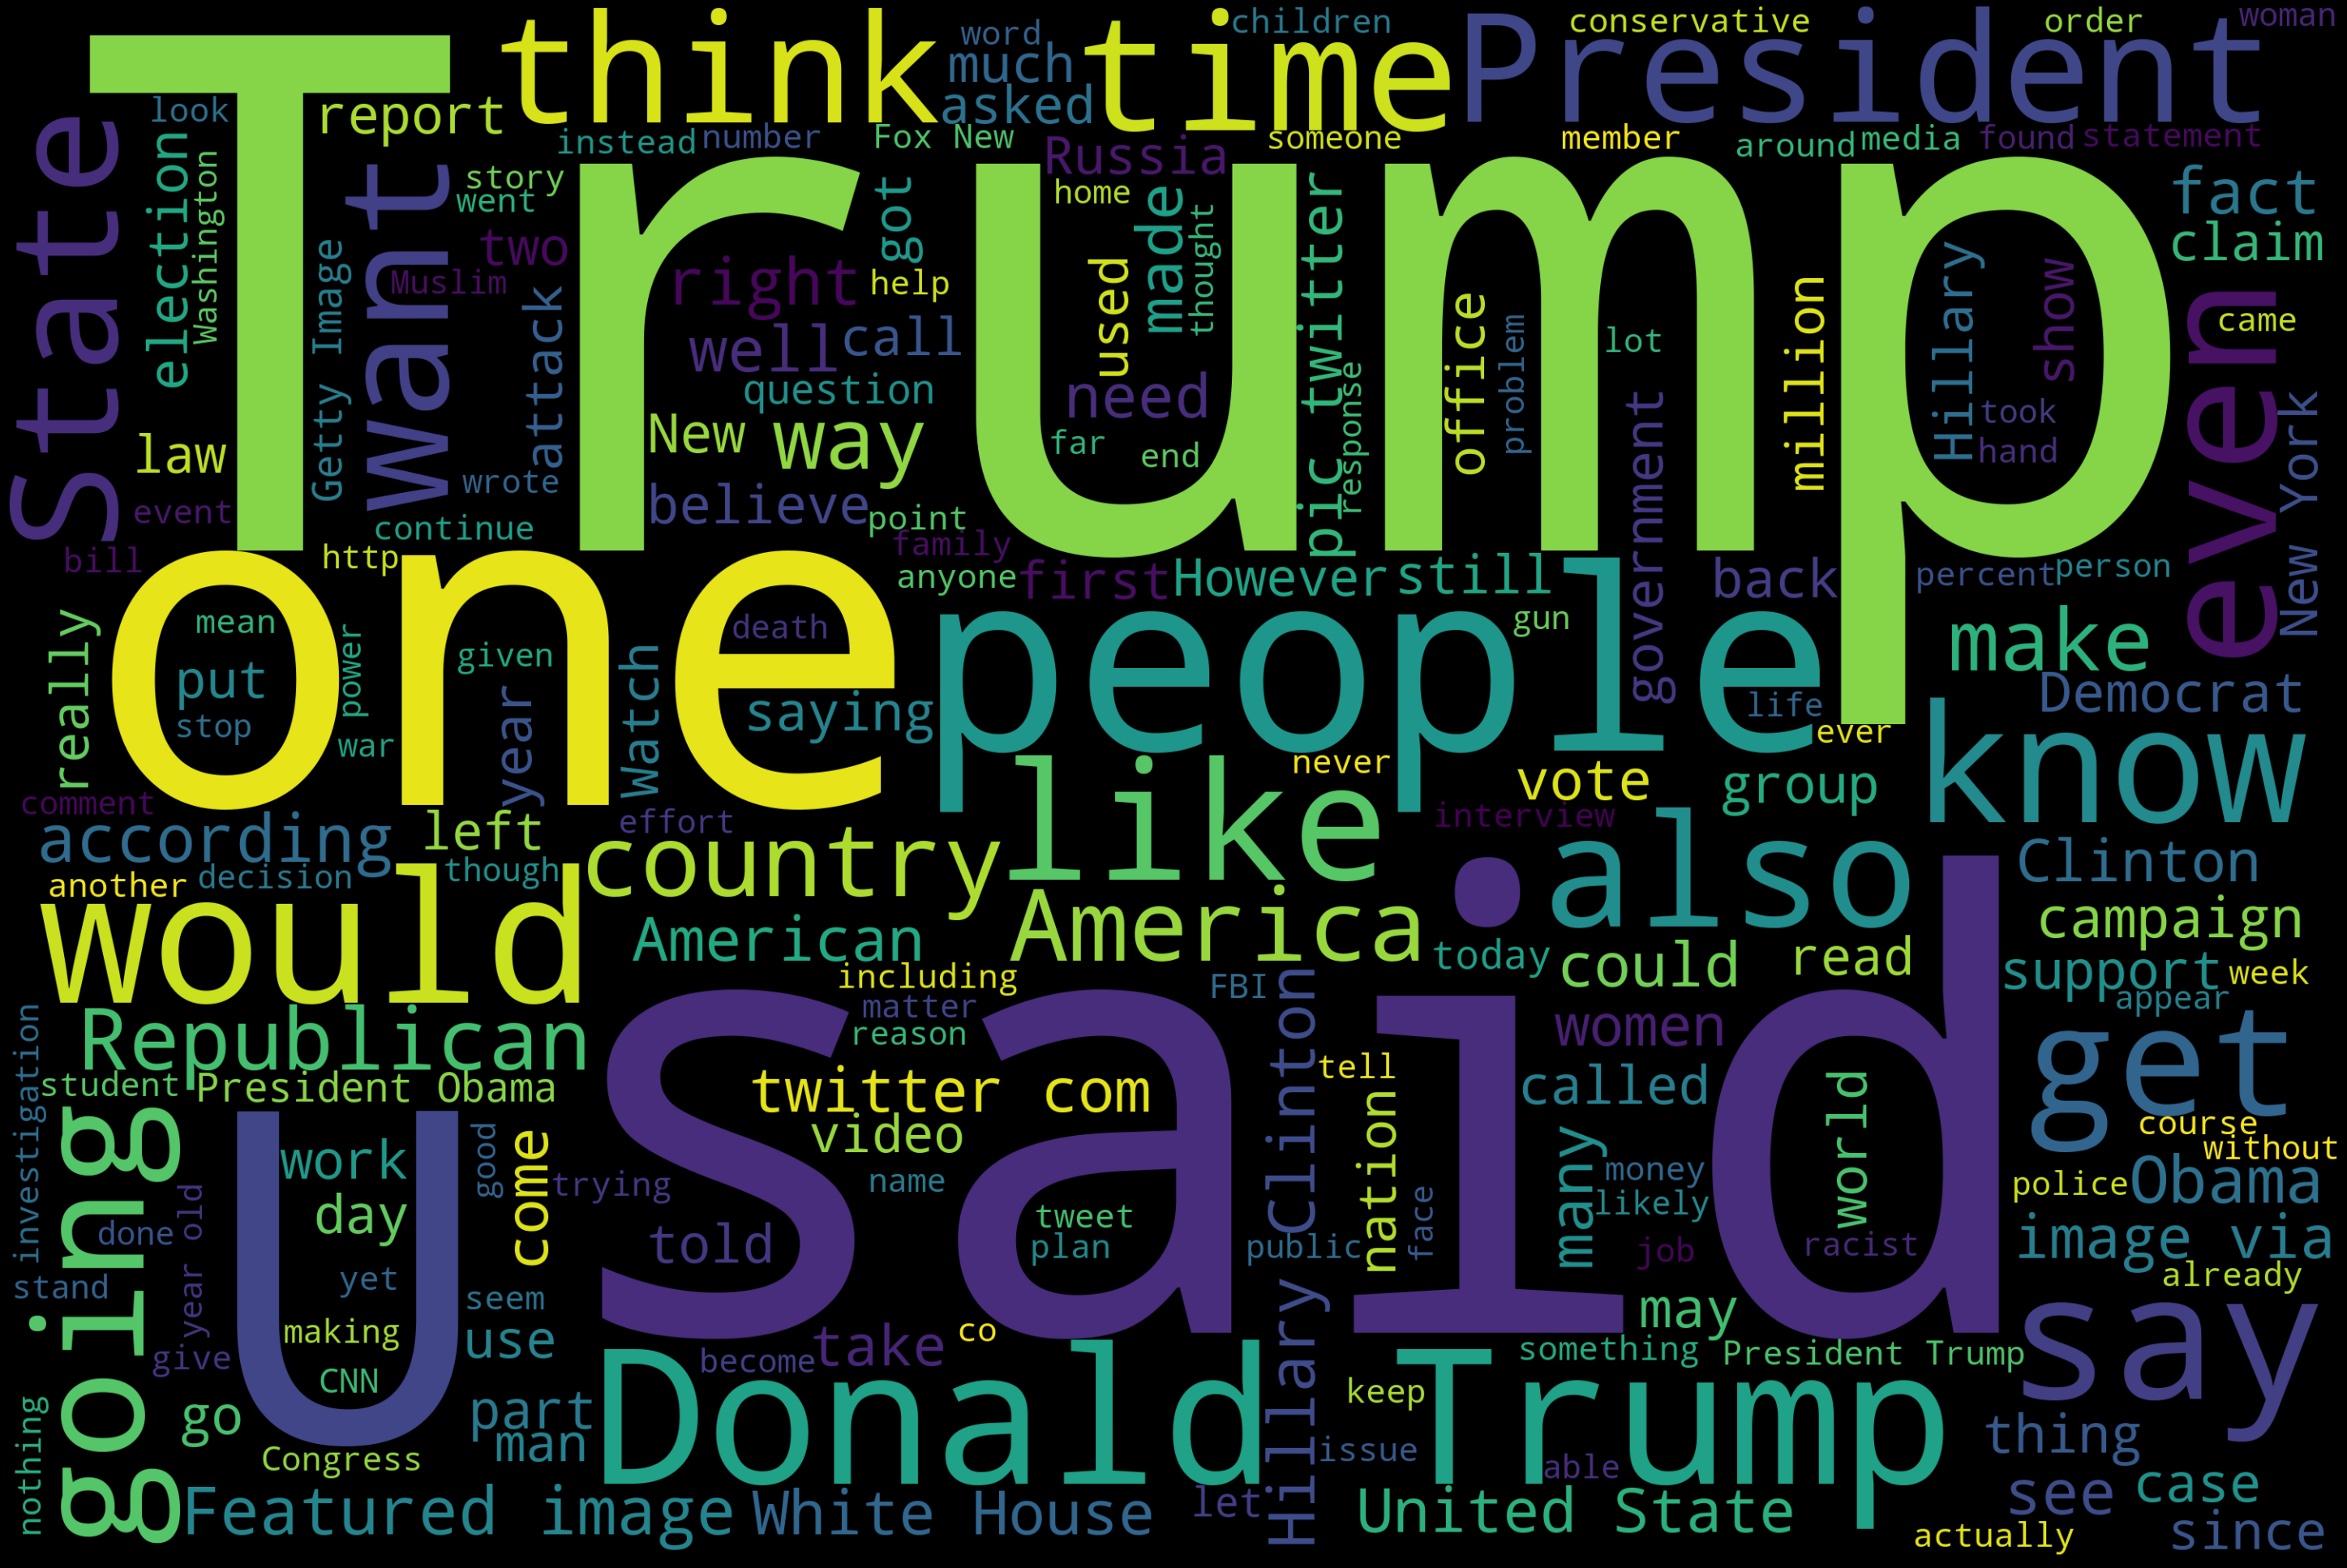

In [7]:
#Word Cloud
text = ''
for news in fake.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# Exploring Real news

In [8]:
real = pd.read_csv("./dataset/data/True.csv")
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


### Difference in Text
Real news seems to have source of publication which is not present in fake news set

Looking at the data:
- most of text contains reuters information such as "**WASHINGTON (Reuters)**".
- Some text are tweets from Twitter 
- Few text do not contain any publication info

# Cleaning Data
Removing Reuters or Twitter Tweet information from the text 

- Text can be splitted only once at " - " which is always present after mentioning source of publication, this gives us publication part and text part
- If we do not get text part, this means publication details was't given for that record
- The Twitter tweets always have same source, a long text of max 259 characters 

In [9]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [10]:
#Thus we have list of indices where publisher is not mentioned
#lets check
real.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

While looking at texts that do not contain publication info such as which reuter, we noticed one thing.

**Text at index 8970 is empty**

In [11]:
real.iloc[8970]
#yep empty
#will remove this soon

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [12]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [13]:
#Replace existing text column with new text
#add seperate column for publication info
real["publisher"] = publisher
real["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [14]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


New column called "Publisher" has been added.


In [15]:
#checking for rows with empty text like row:8970
[index for index,text in enumerate(real.text.values) if str(text).strip() == '']
#seems only one :)

[8970]

In [16]:
#dropping this record
real = real.drop(8970, axis=0)

In [17]:
# checking for the same in fake news
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake.iloc[empty_fake_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


**630 Rows in Fake news with empty text**

Also noticed fake news have a lot of CPATIAL-CASES. Could preserve Cases of letters, but as we are using Google's pretrained word2vec vectors later on, which haswell-formed lower cases word. We will contert to lower case.

The text for these rows seems to be present in title itself. Lets merge title and text to solve these cases.

In [18]:
#Looking at publication Information
# Checking if Some part of text has been included as publisher info... No such cases it seems :)

# for name,count in real.publisher.value_counts().iteritems():
#     print(f"Name: {name}\nCount: {count}\n")

In [19]:
#Getting Total Rows
print(f"Total Records:\t{real.shape[0]}")

#Counting by Subjects 
for key,count in real.subject.value_counts().iteritems():
  print(f"{key}:\t{count}")

Total Records:	21416
politicsNews:	11271
worldnews:	10145


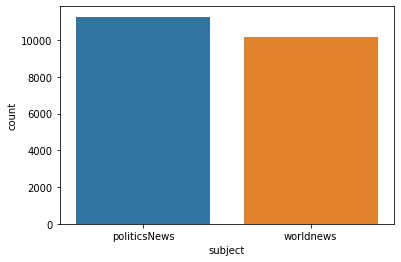

In [20]:
sns.countplot(x="subject", data=real)
plt.show()

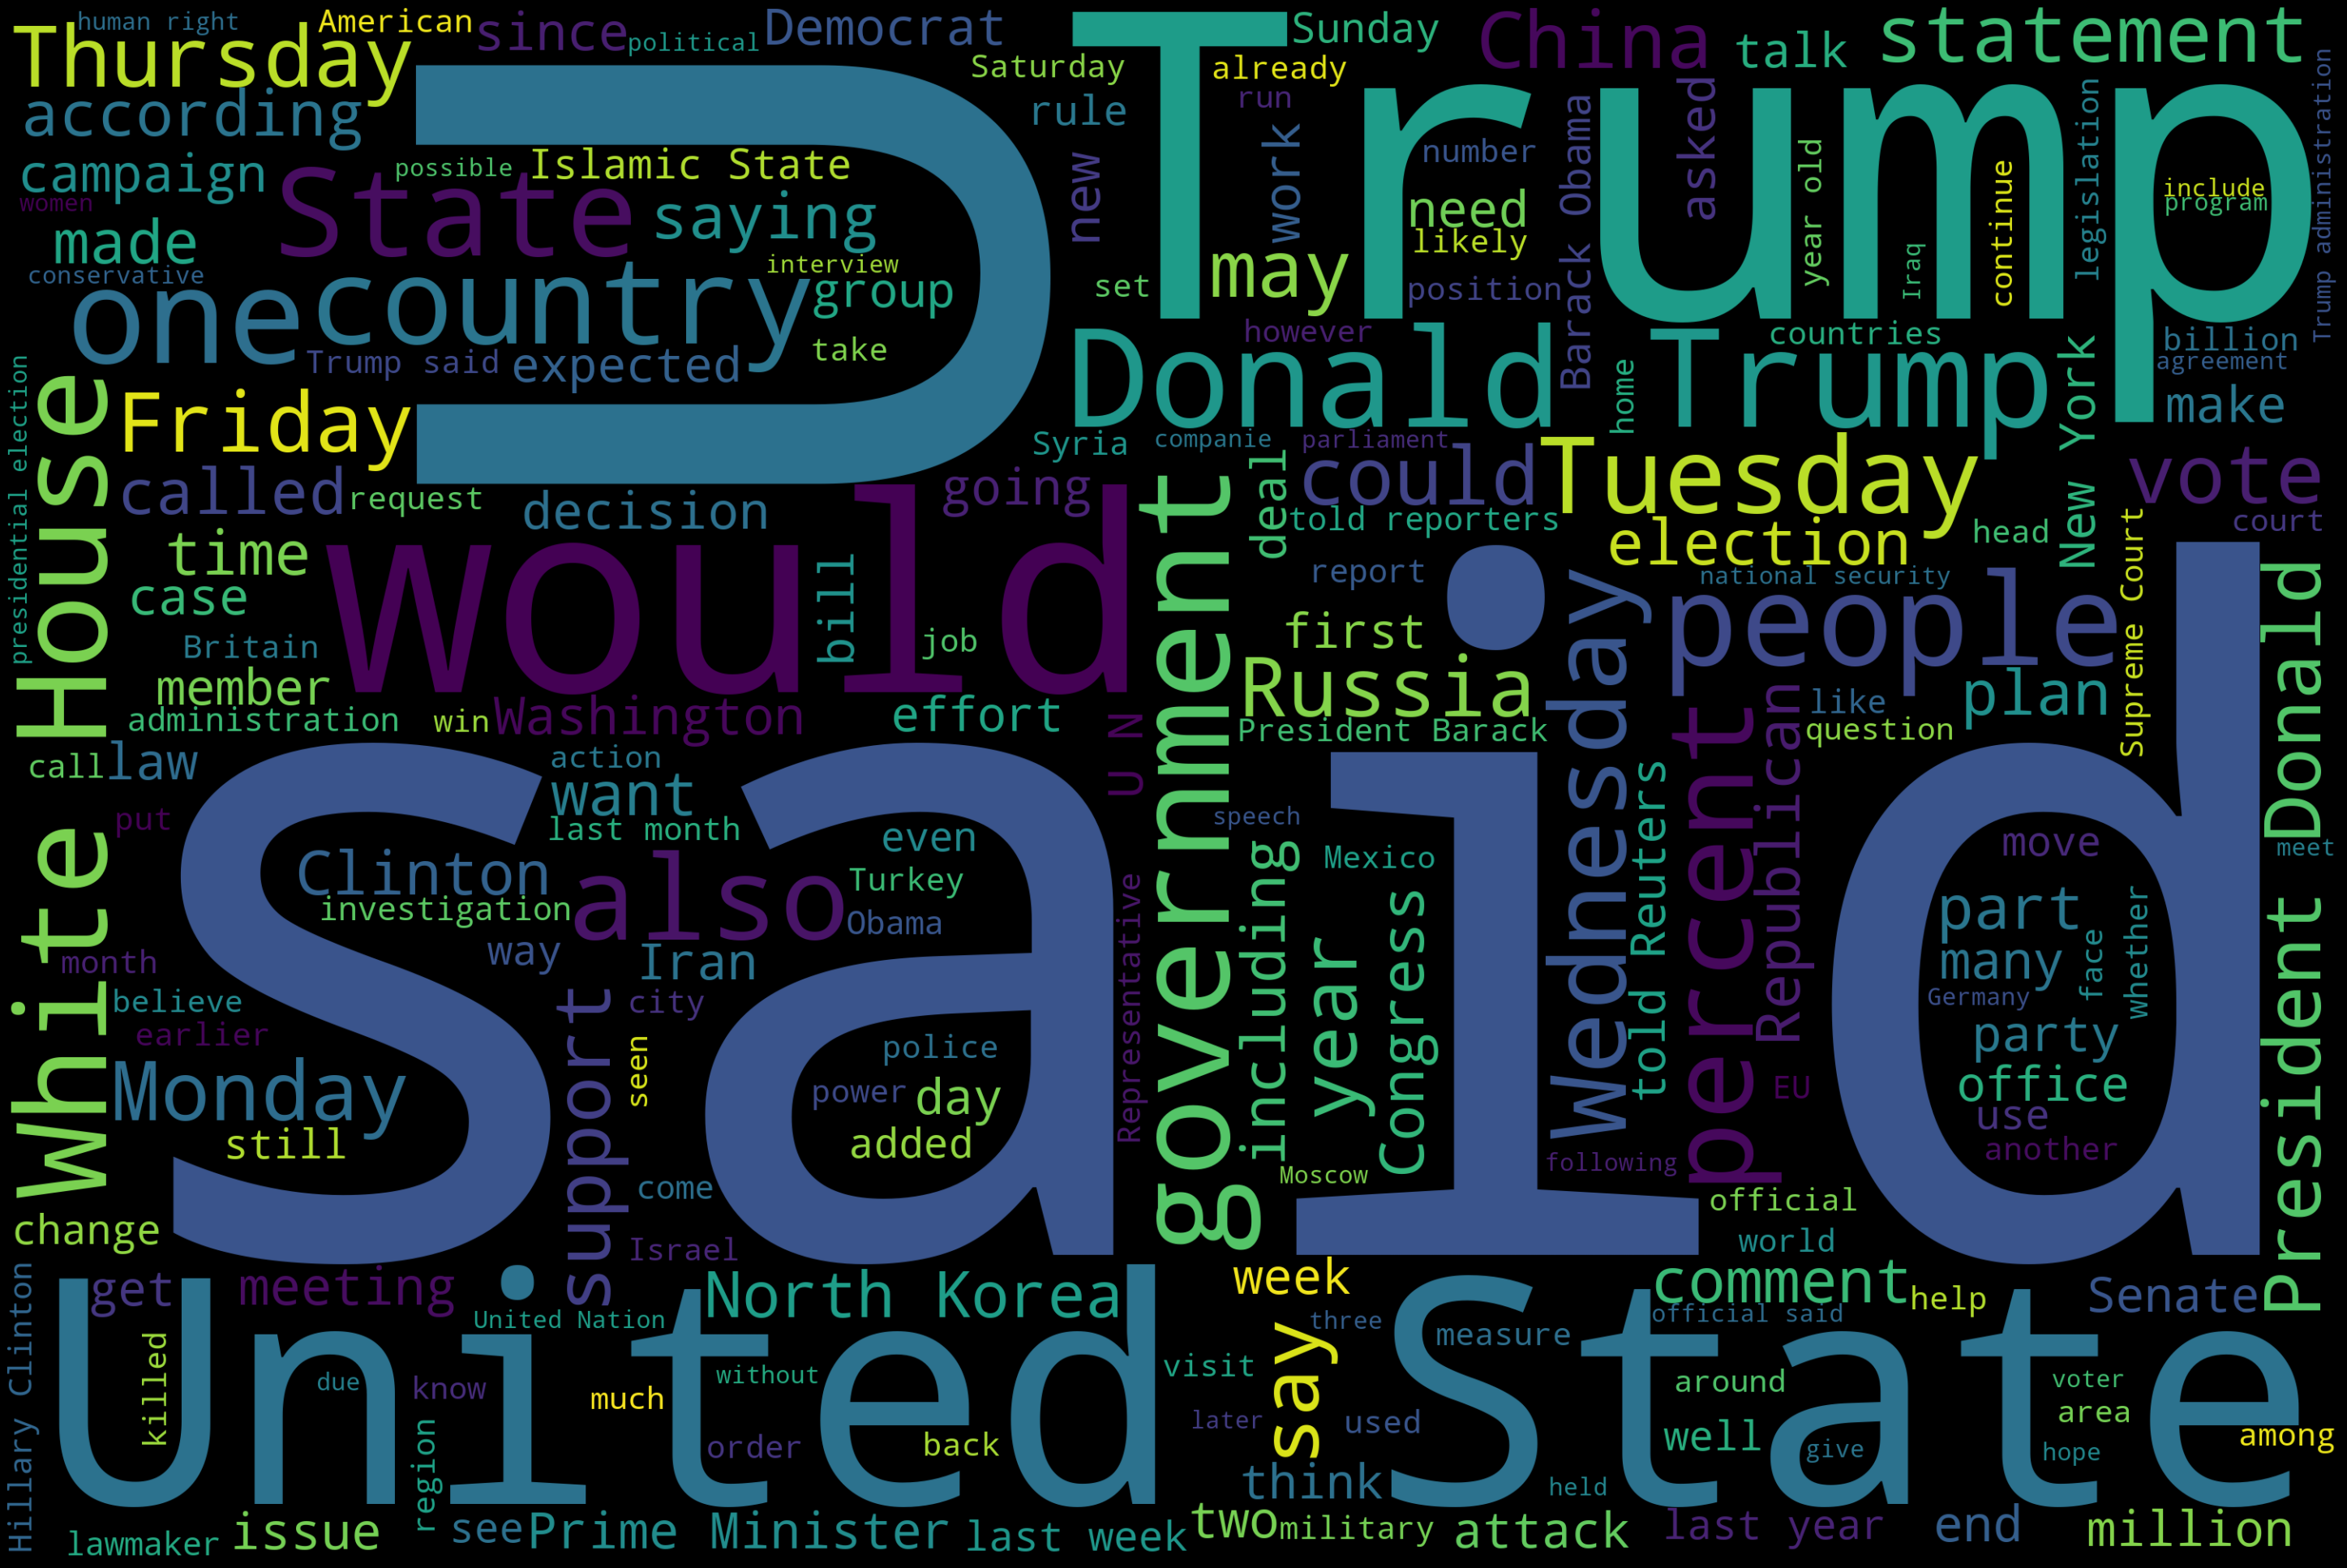

In [21]:
#WordCloud For Real News
text = ''
for news in real.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

# Preprocessing Text

In [22]:
# Adding class Information
real["class"] = 1
fake["class"] = 0

In [23]:
#Combining Title and Text
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [24]:
# Subject is diffrent for real and fake thus dropping it
# Aldo dropping Date, title and Publication Info of real
real = real.drop(["subject", "date","title",  "publisher"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

In [25]:
#Combining both into new dataframe
data = real.append(fake, ignore_index=True)
del real, fake

In [26]:
# Download following if not downloaded in local machine

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ramasubramanian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ramasubramanian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Removing StopWords, Punctuations and single-character words

In [27]:
y = data["class"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del data

### Vectorization -- Word2Vec

Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

[Here](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa) is a nice article about it.




#### Let's create and check our own Word2Vec model with **gensim**

In [28]:
import gensim

In [29]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [30]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each of 122248 words by a 100dim vector.

AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

### Exploring Vectors

Lets checkout these vectors

In [31]:
#see a sample vector for random word, lets say Corona 
w2v_model.wv["corona"]

array([ 0.00927652,  0.04233581, -0.01189919, -0.00637126, -0.01717878,
       -0.07318308,  0.09821472,  0.09481474, -0.05018119, -0.12472641,
       -0.01085156, -0.03136567,  0.01810075, -0.03180546,  0.00541779,
       -0.00218959, -0.04941741, -0.03617164,  0.05008815,  0.00933767,
       -0.02065031,  0.05014593, -0.07417983, -0.02040911,  0.04548199,
       -0.022489  , -0.01938769, -0.00082088, -0.07139963,  0.01544697,
       -0.04592157, -0.05496322, -0.00641575,  0.02426595, -0.00223281,
        0.01582335, -0.00818327, -0.0102728 , -0.01082766, -0.01243694,
        0.00446817, -0.01031495, -0.07328883,  0.00762869,  0.01927168,
        0.06329095, -0.04669759,  0.01762594,  0.01906334, -0.01387223,
       -0.00873613, -0.02109931, -0.01670626, -0.03788047, -0.00505852,
        0.00737444,  0.02929472,  0.00022904, -0.06231963,  0.04992244,
        0.05502415,  0.02748434,  0.01048928, -0.00034035,  0.00553626,
        0.02606114,  0.02788759, -0.01920858, -0.02812771,  0.03

In [32]:
w2v_model.wv.most_similar("iran")

[('tehran', 0.8929640054702759),
 ('iranian', 0.7672280669212341),
 ('hezbollah', 0.6503077149391174),
 ('destabilizing', 0.6384376883506775),
 ('iranians', 0.6263985633850098),
 ('riyadh', 0.6167721152305603),
 ('nuclear', 0.6124117970466614),
 ('jcpoa', 0.5834130644798279),
 ('ankara', 0.5801923274993896),
 ('saudis', 0.5780989527702332)]

In [33]:
w2v_model.wv.most_similar("fbi")

[('comey', 0.7082383632659912),
 ('cia', 0.6233177185058594),
 ('investigation', 0.6199010610580444),
 ('investigators', 0.6151949763298035),
 ('mueller', 0.5997995734214783),
 ('doj', 0.585969865322113),
 ('probe', 0.5625348687171936),
 ('inquiry', 0.5624669194221497),
 ('investigations', 0.5464103817939758),
 ('nunes', 0.5316816568374634)]

In [34]:
w2v_model.wv.most_similar("facebook")

[('reddit', 0.6646246314048767),
 ('gofundme', 0.6472277641296387),
 ('fb', 0.6428275108337402),
 ('instagram', 0.6427716016769409),
 ('google', 0.6250492334365845),
 ('online', 0.5703819394111633),
 ('linkedin', 0.565067708492279),
 ('hashtag', 0.5498200058937073),
 ('posting', 0.5442980527877808),
 ('whatsapp', 0.5433658361434937)]

In [35]:
w2v_model.wv.most_similar("computer")

[('computers', 0.8549190759658813),
 ('software', 0.8090239763259888),
 ('malware', 0.7907702326774597),
 ('electronic', 0.7799248099327087),
 ('laptop', 0.7583174705505371),
 ('scanning', 0.7367786765098572),
 ('detection', 0.719314694404602),
 ('kaspersky', 0.7130368947982788),
 ('encrypted', 0.7087289690971375),
 ('servers', 0.7007302641868591)]

In [36]:
#Feeding US Presidents
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])
#First was Bush

[('elect', 0.5422977209091187),
 ('cruz', 0.533646821975708),
 ('bush', 0.5296142101287842),
 ('incoming', 0.49621808528900146),
 ('hillary', 0.4853876233100891),
 ('crooked', 0.474825382232666),
 ('actually', 0.4739815890789032),
 ('course', 0.44789233803749084),
 ('sanders', 0.44217735528945923),
 ('bartlet', 0.442054808139801)]

**Looking at the similar words, vectors are well formed for these words :)**


These Vectors will be passed to LSTM/GRU instead of words. 1D-CNN can further be used to extract features from the vectors. 


Keras has implementation called "**Embedding Layer**" which would create word embeddings(vectors). Since we did that with gensim's word2vec, we will load these vectors into embedding layer and make the layer non-trainable.




We cannot pass string words to embedding layer, thus need some way to represent each words by numbers.

Tokenizer can represent each word by number

In [37]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [38]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[389, 395, 10495, 54, 5509, 1286, 4840, 315, 205, 16]

In [39]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break        

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


**Notice it starts with 1**


We can pass numerical representation of words into neural network.

We can use Many-To-One (Sequence-To-Word) Model of RNN, as we have many words in news as input and one output ie Probability of being Real.

For Many-To-One model, lets use a fixed size input. 


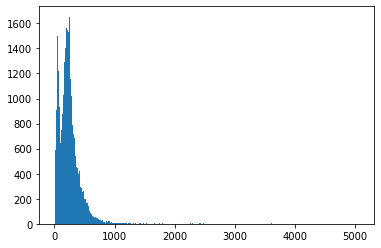

In [40]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :) 

In [41]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])
# Out of 48k news, 44k have less than 700 words

43982

In [42]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [43]:
#all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

700

In [44]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [45]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

We Create a matrix of mapping between word-index and vectors. We use this as weights in embedding layer

Embedding layer accepts numecical-token of word and outputs corresponding vercor to inner layer.

It sends vector of zeros to next layer for unknown words which would be tokenized to 0.


Input length of Embedding Layer is the length of each news (700 now due to padding and truncating)

In [46]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model.wv, word_index)

In [47]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 700, 100)          12224900  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 12,342,277
Trainable params: 117,377
Non-trainable params: 12,224,900
_________________________________________________________________


In [49]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [50]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
737/737 [==============================] - 333s 449ms/step - loss: 0.1344 - acc: 0.9541 - val_loss: 0.0852 - val_acc: 0.9713
Epoch 2/6
737/737 [==============================] - 336s 456ms/step - loss: 0.0687 - acc: 0.9760 - val_loss: 0.0565 - val_acc: 0.9837
Epoch 3/6
737/737 [==============================] - 335s 454ms/step - loss: 0.0328 - acc: 0.9893 - val_loss: 0.0434 - val_acc: 0.9875
Epoch 4/6
737/737 [==============================] - 359s 488ms/step - loss: 0.0253 - acc: 0.9920 - val_loss: 0.0341 - val_acc: 0.9898
Epoch 5/6
737/737 [==============================] - 394s 534ms/step - loss: 0.0212 - acc: 0.9930 - val_loss: 0.0361 - val_acc: 0.9889
Epoch 6/6
737/737 [==============================] - 612s 830ms/step - loss: 0.0103 - acc: 0.9964 - val_loss: 0.0326 - val_acc: 0.9897


In [51]:
#Prediction is in probability of news being real, so converting into classes
#Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [52]:
accuracy_score(y_test, y_pred)

0.9907349665924277

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5832
           1       0.98      1.00      0.99      5393

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225



In [61]:
sample1 = "Obama is the president of US"
samples = [sample1]
sample_tokens = tokenizer.texts_to_sequences(samples)
model.predict(x=sample_tokens)

array([[0.04489726]], dtype=float32)

In [57]:
model.save('./saved_models/fake_new_predictor.h5')

In [60]:
with open('./saved_models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [62]:
tk = tokenizer.texts_to_sequences(["this is a test"])
model.predict(x=tk)

array([[0.76308775]], dtype=float32)